# List of available packages in the current environment  
If LibFEM is missing use one the following commands:
- using Pkg;Pkg.add(PackageSpec(url="https://github.com/amdeld/LibFEM.jl")) 
- ]add https://github.com/amdeld/LibFEM.jl
 

In [1]:
]st

Status `D:\Users\Administrator\OneDrive\Documents\Julia\FEM\Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [0c46a032] DifferentialEquations v6.16.0
  [3625dbae] LibFEM v0.1.0 `https://github.com/amdeld/LibFEM.jl#master`
  [eff96d63] Measurements v2.4.0
  [91a5bcdd] Plots v1.10.1
  [37e2e46d] LinearAlgebra


# Packages loading

In [2]:
using LibFEM ,Plots

# Case Study

In [3]:
#PARAMETERS
const L=10000. #length in mm
const A=100. #cross-sectional area in mm^2
const E=210000. #modulus of elasticity in MPa [steel]
const FM=10000.; #force modulus in N

In [4]:
# ===============================================PRE-PROCESSING==================
# DEFINING AND DISCRETIZING[MESHING] THE STRUCTURE
# connectivity table
# elt||node_i||node_j
# 1|1|3
# 2|2|3
# grid()
X1pos=0.;Y1pos=0.
X2pos=0.;Y2pos=L
X3pos=L;Y3pos=L
#lengths
L1=d2_truss_elementlength(X1pos,Y1pos,X3pos,Y3pos) #length of element 1
L2=d2_truss_elementlength(X2pos,Y2pos,X3pos,Y3pos) #length of element 2
#APPLYING GEOMETRIC&MATERIAL PROPERTIES
A1=sqrt(2)*A; #cross-sectional area of element 1
A2=A; #cross-sectional area of element 2
E1=E; #material of element 1
E2=E; #material of element 2

# Calculation of the stiffness matrix for each finite element

In [5]:
#writing-defining the element stiffness matrices
K1=d2_truss_elementstiffness(E1,A1,L1,45);
println("K1=\r")
K1

K1=


4×4 Array{Float64,2}:
  1050.0   1050.0  -1050.0  -1050.0
  1050.0   1050.0  -1050.0  -1050.0
 -1050.0  -1050.0   1050.0   1050.0
 -1050.0  -1050.0   1050.0   1050.0

In [6]:
K2=d2_truss_elementstiffness(E2,A2,L2,0);
println("K2=\r")
K2

K2=


4×4 Array{Float64,2}:
  2100.0   0.0  -2100.0  -0.0
     0.0   0.0     -0.0  -0.0
 -2100.0  -0.0   2100.0   0.0
    -0.0  -0.0      0.0   0.0

# Calculation of the Global Stiffness Matrix

In [7]:
#ASSEMBLING THE GLOBAL STIFFNESS MATRIX
#matrices initialization
K=zeros(6,6);K1P=zeros(6,6);
#positionning stiffness matrices
K1P=d2_truss_assemble(K,K1,1,3)
println("K1P=\r")
K1P

K1P=


6×6 Array{Float64,2}:
  1050.0   1050.0  0.0  0.0  -1050.0  -1050.0
  1050.0   1050.0  0.0  0.0  -1050.0  -1050.0
     0.0      0.0  0.0  0.0      0.0      0.0
     0.0      0.0  0.0  0.0      0.0      0.0
 -1050.0  -1050.0  0.0  0.0   1050.0   1050.0
 -1050.0  -1050.0  0.0  0.0   1050.0   1050.0

In [8]:
K=zeros(6,6);K2P=zeros(6,6);
K2P=d2_truss_assemble(K,K2,2,3)
println("K2P=\r")
K2P

K2P=


6×6 Array{Float64,2}:
 0.0  0.0      0.0  0.0      0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0
 0.0  0.0   2100.0  0.0  -2100.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0
 0.0  0.0  -2100.0  0.0   2100.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0

In [9]:
#assembling
K=K1P+K2P
println("K=\r")
K

K=


6×6 Array{Float64,2}:
  1050.0   1050.0      0.0  0.0  -1050.0  -1050.0
  1050.0   1050.0      0.0  0.0  -1050.0  -1050.0
     0.0      0.0   2100.0  0.0  -2100.0      0.0
     0.0      0.0      0.0  0.0      0.0      0.0
 -1050.0  -1050.0  -2100.0  0.0   3150.0   1050.0
 -1050.0  -1050.0      0.0  0.0   1050.0   1050.0

# Calcultation of the nodal displacements and the nodal reaction forces

In [10]:
#SOLVING DISPACEMENT EQUATIONS
#extracting displacement submatrix via index vector
K_s=K[5:6,5:6]
#Setting-up the force subvector by applying Load & Boundary Conditions[LBC]]
F_s=[0, -FM]
#solving by gaussian elimination
U_s=K_s\F_s
#SOLVING FORCE EQUATIONS
#setting-up the global nodal displacement vector
U=[0, 0, 0, 0, U_s[1], U_s[2]]
println("U=\r")
U

U=


6-element Array{Float64,1}:
   0.0
   0.0
   0.0
   0.0
   4.761904761904763
 -14.28571428571429

In [11]:
#computing the global nodal force vector
F=K*U
println("F=\r")
F

F=


6-element Array{Float64,1}:
  10000.000000000002
  10000.0
 -10000.000000000002
      0.0
     -1.8189894035458565e-12
 -10000.0

# Calcultation of all the stress, strain, tension quantities for each finite element

In [12]:
#writing the element nodal displacement vectors
U1=[U[1], U[2], U[5], U[6]]
U2=[U[3], U[4], U[5], U[6]]
#computing element strains
ϵ1=d2_truss_elementstrain(L1,45,U1)
@show ϵ1
ϵ2=d2_truss_elementstrain(L2,0,U2)
@show ϵ2;

ϵ1 = [-0.00047619047619047624]
ϵ2 = [0.0004761904761904763]


In [13]:
#computing element forces
f1=d2_truss_elementforce(E1,A1,L1,45,U1)
@show f1
f2=d2_truss_elementforce(E2,A2,L2,0,U2)
@show f2;

f1 = [-14142.135623730956]
f2 = [10000.000000000002]


In [14]:
#computing element stresses
σ1=d2_truss_elementstress(E1,L1,45,U1)
@show σ1
σ2=d2_truss_elementstress(E2,L2,0,U2)
@show σ2;

σ1 = [-100.00000000000004]
σ2 = [100.00000000000001]


# Plot

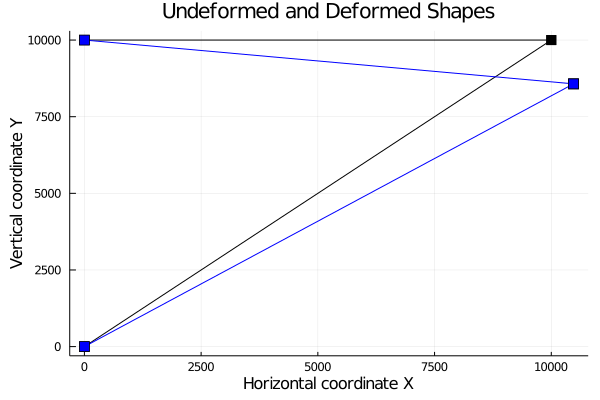

In [15]:
# Plotting
using Plots
Xini = [X1pos, X3pos]
Yini = [Y1pos, Y3pos]
plot(Xini,Yini,label=false,marker=5,shape=:sq,color=:black)
Xini = [X2pos, X3pos]
Yini = [Y2pos, Y3pos]
plot!(Xini,Yini,label=false,marker=5, shape=:sq, color=:black)
fampl = 100
Xdef = [(X1pos + fampl * U[1]), (X3pos + fampl * U[5])]
Ydef = [(Y1pos + fampl * U[1]), (Y3pos + fampl * U[6])]
plot!(Xdef,Ydef,label=false,marker=5,shape=:sq,color=:blue)
Xdef = [(X2pos + fampl * U[3]), (X3pos + fampl * U[5])]
Ydef = [(Y2pos + fampl * U[4]), (Y3pos + fampl * U[6])]
plot!(Xdef,Ydef,label=false,title="Undeformed and Deformed Shapes",xlabel="Horizontal coordinate X", ylabel="Vertical coordinate Y",marker=5,shape=:sq,color=:blue)